# ABox Summary and Descriptive Statistics
This notebook provides an overview of the RDF knowledge graph defined in the ABox.
We compute statistics such as:

- Total number of triples
- Number of distinct classes and properties
- Instances per class
- Triple usage per property

In [15]:
# Run this once if rdflib is not installed
# !pip install rdflib matplotlib pandas

from rdflib import Graph, RDF, RDFS
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
g = Graph()
abox_path = "../GroupIvanWalter-B2-MartinezTroiani.ttl"
g.parse(abox_path, format="turtle")

print(f"Graph loaded with {len(g)} triples.")

Graph loaded with 33313 triples.


In [25]:
def local_name(uri):
    """Extracts the local name after the last '/' or '#' in a URI.
    Special case: show 'rdf:type' for the RDF type property."""
    if str(uri) in ("http://www.w3.org/1999/02/22-rdf-syntax-ns#type", "rdf:type"):
        return "rdf:type"
    return str(uri).split('/')[-1].split('#')[-1]

In [ ]:
# Count instances of each rdf:type (class)
class_counts = defaultdict(int)

for s, p, o in g.triples((None, RDF.type, None)):
    class_counts[o] += 1

# Display as sorted DataFrame
df_classes = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])
df_classes = df_classes.sort_values(by="Count", ascending=False).reset_index(drop=True)
df_classes["Class"] = df_classes["Class"].apply(local_name)
df_classes

,Class,Count
0,http://SDM.org/research/Author,4698
1,http://SDM.org/research/Review,1000
2,http://SDM.org/research/Paper,1000
3,http://SDM.org/research/Volume,376
4,http://SDM.org/research/Journal,318
5,http://SDM.org/research/Edition,265
6,http://SDM.org/research/Proceedings,215
7,http://SDM.org/research/Conference,193
8,http://SDM.org/research/Workshop,50
9,http://SDM.org/research/Topic,43


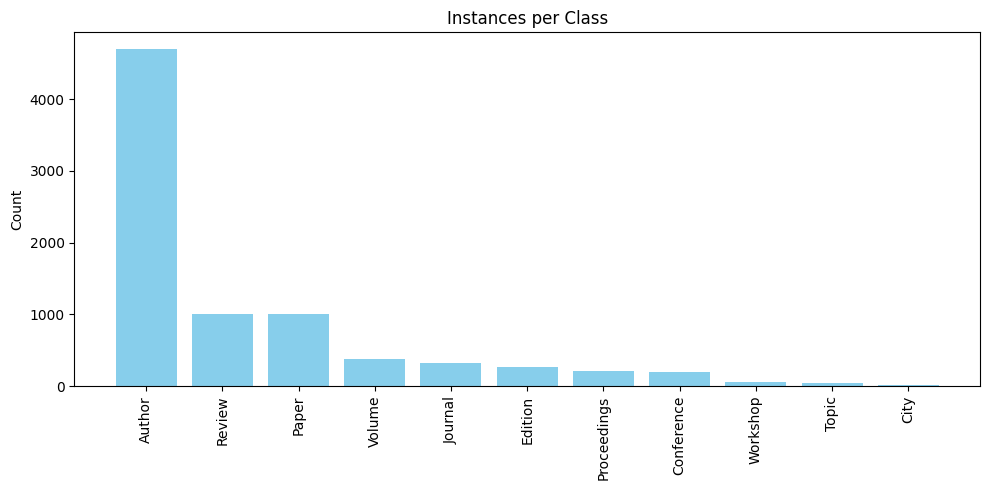

In [20]:
# Barplot of instances per class
plt.figure(figsize=(10, 5))
plt.bar(df_classes["Class"].apply(local_name), df_classes["Count"], color="skyblue")
plt.xticks(rotation=90)
plt.title("Instances per Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [27]:
# Count of properties (predicates)
property_counts = Counter(p for s, p, o in g)

df_props = pd.DataFrame(property_counts.items(), columns=["Property", "Count"])
df_props = df_props.sort_values(by="Count", ascending=False).reset_index(drop=True)
df_props["Property"] = df_props["Property"].apply(local_name)
df_props

,Property,Count
0,cites,9945
1,rdf:type,8174
2,hasAuthor,4719
3,performedBy,3000
4,hasReview,1000
5,aboutTopic,1000
6,hasContent,1000
7,hasCorrespondingAuthor,992
8,publishedIn,425
9,hasVolume,381


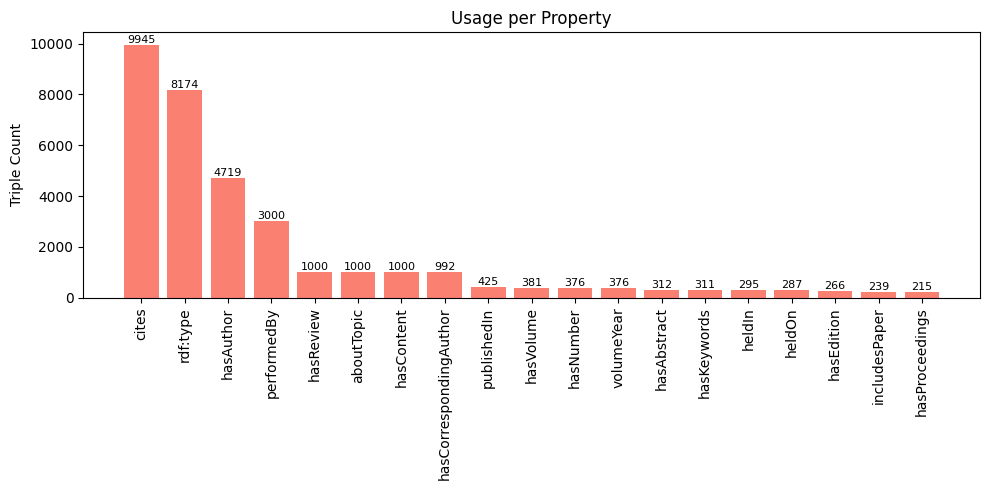

In [26]:
# Barplot of properties used
plt.figure(figsize=(10, 5))
bars = plt.bar(df_props["Property"].apply(local_name), df_props["Count"], color="salmon")
plt.xticks(rotation=90)
plt.title("Usage per Property")
plt.ylabel("Triple Count")

# Add frequency labels on top of each bar
for bar, count in zip(bars, df_props["Count"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(count),
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

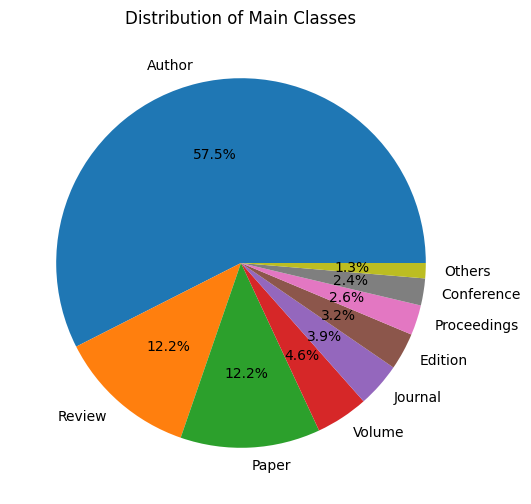

In [23]:
# Pie chart of most frequent class types
# Show only top 8 classes, aggregates the rest as "Others"
top_n = 8
df_sorted = df_classes.sort_values(by="Count", ascending=False).reset_index(drop=True)
df_top = df_sorted.iloc[:top_n]
others_count = df_sorted.iloc[top_n:]["Count"].sum()
labels = df_top["Class"].apply(local_name).tolist()
sizes = df_top["Count"].tolist()
if others_count > 0:
    labels.append("Others")
    sizes.append(others_count)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Main Classes")
plt.show()